# Setting up Fisher matrix calculation

In [1]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from IPython.display import display, clear_output

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
fsize=14

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing
######################################################

ln10e10As = 3.044

planck_baseline_params = {
    "omega_b": 0.02237,
    "omega_cdm": 0.1200,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.36
}

planck_baseline_sigma = {
    "omega_b": 0.00015,
    "omega_cdm": 0.0012,
    "n_s": 0.0042,
    "tau_reio": 0.0073,
    "ln10^{10}A_s": 0.014,
    "H0": 0.54
}

######################################################
#  Configuring the run
######################################################


common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }

#LCDM parameters
for name, value in planck_baseline_params.items():
    common_settings.update({name: value})

pr_cover_tau = 0.004
precision_settings = {"start_sources_at_tau_c_over_tau_h": pr_cover_tau}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
print(Class.__file__)

/Users/gabe/.local/lib/python3.9/site-packages/classy-2.9.0-py3.9-macosx-10.9-x86_64.egg/classy.cpython-39-darwin.so


In [2]:
M.compute()

# Finding perturbation $z_{min}$ and $z_{max}$

In [3]:
from scipy.interpolate import interp1d

fiducial_thermo = M.get_thermodynamics()
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
ll_max = 2500
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Fiducial quantities
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]
xe_fid = fiducial_thermo["x_fid"]
viz_fid = fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"]

Yp_fid = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max_fid = 1 + Yp_fid/2*(1-Yp_fid)

######################################################
# z_min and z_max are set by picking some 
# threshold where the visibility function equals
# a given percentage of its maximum
######################################################

ind_max = np.argmax(viz_fid)
max_viz = viz_fid[ind_max]

highz_percent_cutoff = 0.2
lowz_percent_cutoff = 0.05

test = np.where(viz_fid<highz_percent_cutoff*max_viz, 1, 0) #when true, array will be 1, 0 when false
ind_highz = np.argwhere(np.diff(test)==1)[0][0] #finds first index where we switch from true to false

test = np.where(viz_fid<lowz_percent_cutoff*max_viz, 1, 0)
ind_lowz = np.argwhere(np.diff(test)==-1)[0][0]

print("Viz function has value {0} at index {1} and redshift {2}".format(viz_fid[ind_highz], ind_highz, fiducial_thermo['z'][ind_highz]))
print("{0:.2f}*viz_max = {1}".format(highz_percent_cutoff, highz_percent_cutoff*max_viz))

print("Viz function has value {0} at index {1} and redshift {2}".format(viz_fid[ind_lowz], ind_lowz, fiducial_thermo['z'][ind_lowz]))
print("{0:.2f}*viz_max = {1}".format(lowz_percent_cutoff, lowz_percent_cutoff*max_viz))

######################################################
# Setting string of control point pivots
# First varied pivot will be at redshift
# found above
######################################################

num_control_points = 4
free_pivots = np.linspace(start=np.floor(fiducial_thermo['z'][ind_lowz]), stop=np.floor(fiducial_thermo['z'][ind_highz]), num=num_control_points)
dz_pivot = np.diff(free_pivots)[0]
zmin_pert = free_pivots[0] - dz_pivot
zmax_pert = free_pivots[-1] + dz_pivot

print(zmin_pert)

pivots = np.insert(free_pivots, 0, zmin_pert)
pivots = np.append(pivots, zmax_pert)

str_pivots = ["{:.4f}".format(p) for p in pivots]
str_pivots = ",".join(str_pivots)
print(str_pivots)

Viz function has value 0.004296229970380346 at index 2909 and redshift 1221.0
0.20*viz_max = 0.004246059483756924
Viz function has value 0.0010608444670408507 at index 2108 and redshift 820.5
0.05*viz_max = 0.001061514870939231
686.3333333333334
686.3333,820.0000,953.6667,1087.3333,1221.0000,1354.6667


# Setting up Fisher calculation


In [4]:
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
from RecTools import *

#######################################################
# Fisher parameters
######################################################

# reproducing here the fiducial cosmology for clarity

ln10e10As = 3.044

planck_baseline_params = {
    "omega_b": 0.02237,
    "omega_cdm": 0.1200,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.36
}

noise_parameters = {'beam_FWHM_143_arcmin' : 7.3,
                        'beam_FWHM_217_arcmin' : 4.90,
                        'weight_inv_T_143' : 0.36e-4,
                        'weight_inv_P_143' : 1.61e-4,
                        'weight_inv_T_217' : 0.78e-4,
                        'weight_inv_P_217' : 3.25e-4,
                        'fsky' : 0.8,
                        'use_143' : True,
                        'use_217' : True
                        }  

#for now just do a 'standard' fisher calculation
recombination_params = {"zmin_pert": zmin_pert,
                        "zmax_pert": zmax_pert,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'control',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "xe_control_pivots": str_pivots
                        }

#######################################################
# Fisher calculation
######################################################

In [5]:
calc = FisherCalculator(planck_baseline_params, recombination_params, "test")
target_params = [*planck_baseline_params.keys(), 'xe_control_points']
print(target_params)
fm = calc.compute_Fisher(target_params)
#print(list(planck_baseline_params.keys()))

['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0', 'xe_control_points']
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0', 'xe_control_points']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
q_1
q_2
q_3
q_4
Fisher matrices calculation completed at 10/25/2022, 16:15:42


In [7]:
marg = fm.get_marginalized_matrix(["H0", "omega_b"])
print(fm.col_names)
print(marg)
print(fm.class_parameters)
print(fm.fisher_settings)

TypeError: only integer scalar arrays can be converted to a scalar index

AttributeError: 'FisherMatrix' object has no attribute 'cosmo_params'

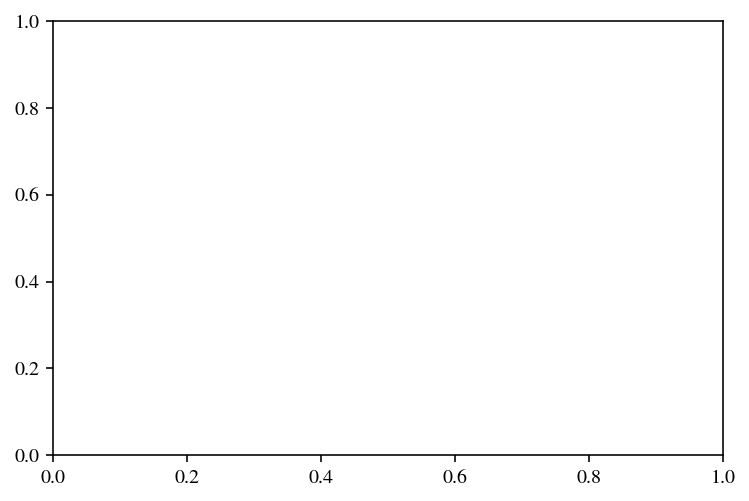

In [ ]:
fig,ax = plt.subplots()

print(fm.ellipse2d(["q_1", "q_2"]))
ax.add_patch(fm.ellipse2d(["q_1", "q_2"]))
ax.set_xlim([0.118, 0.123])
ax.set_ylim([66, 70])
plt.show()